In [17]:
import tiktoken
import torch 
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch import nn
import os
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [3]:
BASE_CONFIG = { 
 "vocab_size": 50257, 
 "context_length": 1024, 
 "drop_rate": 0.0, 
 "qkv_bias": True 
}

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")

In [7]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length, pad_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_text = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        self.encoded_text = [
            encoded_text[:self.max_length] for encoded_text in self.encoded_text
        ]
        self.encoded_text = [
            encoded_text + [pad_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_text
        ]
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_text:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
    def __getitem__(self, index):
        encoded = self.encoded_text[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    def __len__(self):
        return len(self.data)

In [10]:
train_dataset = SpamDataset(
    csv_file="../dataset/train.csv",
    tokenizer=tokenizer,
    max_length=None
)
val_dataset = SpamDataset(
    csv_file="../dataset/test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length,
)
test_dataset = SpamDataset(
    csv_file="../dataset/test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [11]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [12]:
for input_batch, target_batch in train_loader: 
 pass 
print("Input batch dimensions:", input_batch.shape) 
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 104])
Label batch dimensions torch.Size([8])


In [13]:
print(f"{len(train_loader)} training batches") 
print(f"{len(val_loader)} validation batches") 
print(f"{len(test_loader)} test batches")

130 training batches
38 validation batches
38 test batches


In [14]:
def text_to_id(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def id_to_text(id, tokenizer):
    flat = id.squeeze(0)
    return tokenizer.decode(flat.tolist())
def generate_text_simple(model, idx, max_text, context_size):
    for _ in range(max_text):
        idx = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx)
        logits = logits[:, -1, :]
        idx_text = torch.softmax(logits, dim = -1)
        idx_next = torch.argmax(idx_text, dim = -1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim = -1)
    return idx

In [18]:
model = GPT2LMHeadModel.from_pretrained("gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

c:\Users\29611\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\29611\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performan

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [22]:
model.eval()
text1 = "Every effort moves you"
inputs_id = tokenizer.encode(text1)
input_tensor = torch.tensor(inputs_id).unsqueeze(0)
with torch.no_grad():
    output = model.generate(input_tensor, max_length = 50, num_return_sequences=1)
generate_ids = output[0].tolist()
generate_text1 = tokenizer.decode(generate_ids)
print(generate_text1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance of your work.

The third step is to understand the importance of your work.




In [23]:
for param in model.parameters():
    param.requires_grad = False

In [24]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [26]:
model.lm_head = nn.Linear(in_features=768, out_features=2)

In [27]:
transformer_blocks = model.transformer.h
last_block_index = len(transformer_blocks) - 1
for param in transformer_blocks[last_block_index].parameters():
    param.requires_grad = True
model.transformer.ln_f.requires_grad = True

In [28]:
# 输出确认状态
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"可训练参数: {name}")

可训练参数: transformer.h.11.ln_1.weight
可训练参数: transformer.h.11.ln_1.bias
可训练参数: transformer.h.11.attn.c_attn.weight
可训练参数: transformer.h.11.attn.c_attn.bias
可训练参数: transformer.h.11.attn.c_proj.weight
可训练参数: transformer.h.11.attn.c_proj.bias
可训练参数: transformer.h.11.ln_2.weight
可训练参数: transformer.h.11.ln_2.bias
可训练参数: transformer.h.11.mlp.c_fc.weight
可训练参数: transformer.h.11.mlp.c_fc.bias
可训练参数: transformer.h.11.mlp.c_proj.weight
可训练参数: transformer.h.11.mlp.c_proj.bias
可训练参数: lm_head.weight
可训练参数: lm_head.bias


### 计算分类和损失

In [41]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (inputs, targets) in enumerate(data_loader):
        if i < num_batches:
            inputs.to(device)
            targets.to(device)
            with torch.no_grad():
                output = model(inputs)
                logits = output.logits[:, -1, :]
            prediction_label = torch.argmax(logits, dim = -1)
            num_examples += len(prediction_label)
            correct_predictions += ((prediction_label == targets).sum().item())
        else:
            break
    if num_examples == 0:
        return 1
    return correct_predictions / num_examples

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device) 
torch.manual_seed(123) 
train_accuracy = calc_accuracy_loader( 
 train_loader, model, device, num_batches=10 
) 
val_accuracy = calc_accuracy_loader( 
 val_loader, model, device, num_batches=10 
) 
test_accuracy = calc_accuracy_loader( 
 test_loader, model, device, num_batches=10 
) 
print(f"Training accuracy: {train_accuracy*100:.2f}%") 
print(f"Validation accuracy: {val_accuracy*100:.2f}%") 
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 57.50%
Test accuracy: 57.50%


In [43]:
def calc_loss_batch(input, target, model, device):
    input.to(device)
    target.to(device)
    output = model(input)
    logits = output.logits[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target)
    return loss

In [46]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches == None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (inputs, targets) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(inputs, targets, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [47]:
with torch.no_grad(): 
 train_loss = calc_loss_loader( 
 train_loader, model, device, num_batches=5 
 ) 
 val_loss = calc_loss_loader(val_loader, model, device, num_batches=5) 
 test_loss = calc_loss_loader(test_loader, model, device, num_batches=5) 
print(f"Training loss: {train_loss:.3f}") 
print(f"Validation loss: {val_loss:.3f}") 
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.631
Validation loss: 2.134
Test loss: 2.134


In [48]:
def evaluate_model(mode, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [50]:
def classifier_finetuning(model, train_loader, val_loader, optimizer, 
                          device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input, target in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input, target, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): " 
                      f"Train loss {train_loss:.3f}, " 
                      f"Val loss {val_loss:.3f}")
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="") 
        print(f"Validation accuracy: {val_accuracy*100:.2f}%") 
        train_accs.append(train_accuracy) 
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [51]:
import time 
start_time = time.time() 
torch.manual_seed(123) 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1) 
num_epochs = 5 
train_losses, val_losses, train_accs, val_accs, example_seen = classifier_finetuning(
    model, train_loader, val_loader, optimizer=optimizer, device=device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5
) 
end_time = time.time() 
execution_time_minutes = (end_time - start_time) / 60 
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.168, Val loss 2.054
Ep 1 (Step 000050): Train loss 0.698, Val loss 0.665
Ep 1 (Step 000100): Train loss 0.656, Val loss 0.638
Training accuracy: 62.50% | Validation accuracy: 57.50%
Ep 2 (Step 000150): Train loss 0.614, Val loss 0.592
Ep 2 (Step 000200): Train loss 0.547, Val loss 0.507
Ep 2 (Step 000250): Train loss 0.345, Val loss 0.302
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.204, Val loss 0.127
Ep 3 (Step 000350): Train loss 0.077, Val loss 0.063
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.050, Val loss 0.068
Ep 4 (Step 000450): Train loss 0.133, Val loss 0.053
Ep 4 (Step 000500): Train loss 0.040, Val loss 0.042
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.027, Val loss 0.035
Ep 5 (Step 000600): Train loss 0.010, Val loss 0.041
Training accuracy: 97.50% | Validation accuracy: 97.50%
Training completed in 12.66 mi

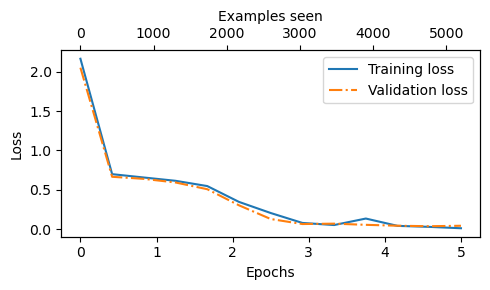

In [52]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, 
    label="loss"): 
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}") 
    ax1.plot( epochs_seen, val_values, linestyle="-.", label=f"Validation {label}") 
    ax1.set_xlabel("Epochs") 
    ax1.set_ylabel(label.capitalize()) 
    ax1.legend() 
    ax2 = ax1.twiny() 
    ax2.plot(examples_seen, train_values, alpha=0) 
    ax2.set_xlabel("Examples seen") 
    fig.tight_layout() 
    plt.savefig(f"{label}-plot.pdf") 
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)) 
examples_seen_tensor = torch.linspace(0, example_seen, len(train_losses)) 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

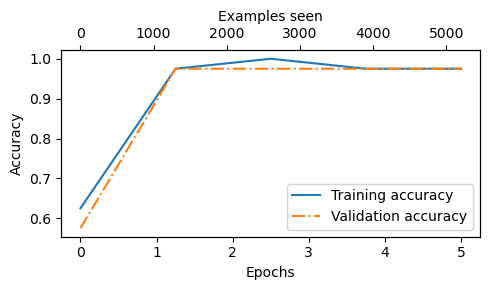

In [53]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs)) 
examples_seen_tensor = torch.linspace(0, example_seen, len(train_accs)) 
plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs, 
    label="accuracy")

In [54]:
train_accuracy = calc_accuracy_loader(train_loader, model, device) 
val_accuracy = calc_accuracy_loader(val_loader, model, device) 
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%") 
print(f"Validation accuracy: {val_accuracy*100:.2f}%") 
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.79%
Validation accuracy: 96.33%
Test accuracy: 96.33%


In [58]:
print(dir(model))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adjust_missing_and_unexpected_keys', '_apply', '_assisted_decoding', '_auto_class', '_backward_compatibility_gradient_checkpointing', '_backward_hooks', '_backward_pre_hooks', '_beam_search', '_beam_search_has_unfinished_sequences', '_buffers', '_cache_dependant_input_preparation', '_cache_dependant_input_preparation_exporting', '_call_impl', '_can_compile_fullgraph', '_can_record_outputs', '_can_set_attn_implementation', '_check_and_adjust_attn_implementation', '_check_early_stop_heuristic', '_checkpoint_conversion_mapping', '_compiled_call_impl', '_c

In [63]:
def calssify_review(text, model, tokenizer, device, max_length=None,
                    pad_token = 50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    support_context_length = model.transformer.wte.weight.shape[1]
    input_ids = input_ids[:min(max_length, support_context_length)]
    
    input_ids += [pad_token] * (max_length - len(input_ids))
    input_ids = torch.tensor(input_ids, device = device).unsqueeze(0)
    with torch.no_grad():
        output = model(input_ids)
        logits = output.logits[:, -1, :]
    prediction_label = torch.argmax(logits, dim = -1).item()
    return "垃圾邮件" if prediction_label == 1 else "不是垃圾邮件"

In [64]:
text_1 = ( 
 "You are a winner you have been specially" 
 " selected to receive $1000 cash or a $2000 award." 
) 
print(calssify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

垃圾邮件


In [66]:
text_2 = ( 
 "Hey, just wanted to check if we're still on" 
 " for dinner tonight? Let me know!" 
) 
print(calssify_review( 
 text_2, model, tokenizer, device, max_length=train_dataset.max_length 
))

不是垃圾邮件


In [67]:
torch.save(model.state_dict(), "review_classifier.pth")